In [255]:
from datetime import datetime, date
import pandas as pd
from pytz import timezone
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Stations, units
import numpy as np

In [256]:
# Set time period
end = datetime.now()
# loc_dt.strftime(fmt)
start = datetime(end.year - 30, end.month, end.day)
# start = datetime(1973, 1, 1)

# Create Point for Vancouver, BC
nyc = Point(40.7789, -73.9692, 3.0)

# Get daily data for 2018
data = Daily(nyc, start, end)
data = data.convert(units.imperial)
data = data.fetch()

daily_max = data.tmax

In [257]:
data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1993-06-01,66.7,57.9,77.0,0.031,0.0,303.0,14.3,39.1,1007.2,NaN
1993-06-02,60.6,43.0,72.0,0.000,0.0,270.0,7.2,21.9,1013.5,NaN
1993-06-03,68.7,59.0,80.1,0.000,0.0,245.0,7.6,16.1,1011.2,NaN
1993-06-04,64.8,55.9,74.8,0.051,0.0,NaN,6.5,25.3,1011.0,NaN
1993-06-05,61.7,57.9,64.9,0.181,0.0,NaN,8.1,21.9,1012.9,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-05-28,67.8,60.1,78.1,0.000,NaN,218.0,3.5,NaN,1020.0,NaN
2023-05-29,69.1,61.0,79.0,0.000,NaN,71.0,6.8,NaN,1017.3,NaN
2023-05-30,61.9,55.4,71.1,0.000,NaN,68.0,5.4,NaN,1022.8,NaN


In [258]:
data['month'], data['day'] = data.index.month, data.index.day


In [259]:
data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,month,day
time,,,,,,,,,,,,
1993-06-01,66.7,57.9,77.0,0.031,0.0,303.0,14.3,39.1,1007.2,NaN,6,1
1993-06-02,60.6,43.0,72.0,0.000,0.0,270.0,7.2,21.9,1013.5,NaN,6,2
1993-06-03,68.7,59.0,80.1,0.000,0.0,245.0,7.6,16.1,1011.2,NaN,6,3
1993-06-04,64.8,55.9,74.8,0.051,0.0,NaN,6.5,25.3,1011.0,NaN,6,4
1993-06-05,61.7,57.9,64.9,0.181,0.0,NaN,8.1,21.9,1012.9,NaN,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-28,67.8,60.1,78.1,0.000,NaN,218.0,3.5,NaN,1020.0,NaN,5,28
2023-05-29,69.1,61.0,79.0,0.000,NaN,71.0,6.8,NaN,1017.3,NaN,5,29
2023-05-30,61.9,55.4,71.1,0.000,NaN,68.0,5.4,NaN,1022.8,NaN,5,30


In [260]:
daily_max_avg = pd.DataFrame(data.tmax.groupby(by=[data.month, data.day]).mean())
daily_max_max = pd.DataFrame(data.tmax.groupby(by=[data.month, data.day]).max())

In [261]:
daily_max_avg

tmax
month day           
1     1    42.603333
      2    42.493333
      3    40.960000
      4    41.800000
      5    40.416667
...              ...
12    27   42.026667
      28   44.100000
      29   42.370000
      30   41.256667
      31   41.366667

[366 rows x 1 columns]

In [262]:
daily_max_avg['time'] = daily_max_avg.index.values
daily_max_avg

tmax      time
month day                     
1     1    42.603333    (1, 1)
      2    42.493333    (1, 2)
      3    40.960000    (1, 3)
      4    41.800000    (1, 4)
      5    40.416667    (1, 5)
...              ...       ...
12    27   42.026667  (12, 27)
      28   44.100000  (12, 28)
      29   42.370000  (12, 29)
      30   41.256667  (12, 30)
      31   41.366667  (12, 31)

[366 rows x 2 columns]

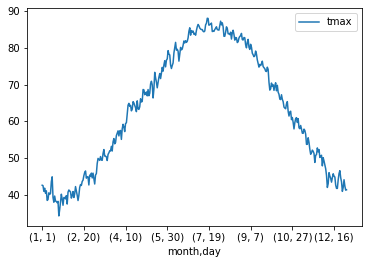

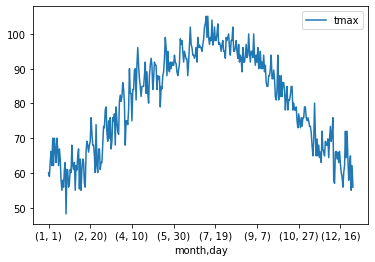

In [263]:
daily_max_avg.plot()
daily_max_max.plot()
plt.show()

In [264]:
# is today hotter than average
today = end.strftime('%Y-%m-%d')
month, day = end.month, end.day

todays_temp = data.tmax.loc[today]
todays_avg_high = daily_max_avg.tmax.loc[(month, day)]
todays_max_high = daily_max_max.tmax.loc[(month, day)]

In [265]:
todays_temp, todays_avg_high, todays_max_high

(78.8, 78.29354838709678, 91.9)